# Поиск близких маршрутов
Данный метод основан на кластеризации точек в пространстве по группам

In [ ]:
import sqlalchemy as sa
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import geopandas as gp
from shapely.geometry import Point
from haversine import haversine, Unit
from sklearn.feature_extraction.text import TfidfVectorizer


In [3]:
# настройка для выбора кол-ва кластеров для пользователя
n_clusters = 15

In [4]:
engine = sa.create_engine(os.environ['db'])


Так как у нас один пользователь, то мы берем все координаты из бд

In [5]:
df_sql = pd.read_sql("select name,data from routes;", engine)
coords = []
for i, row in df_sql.iterrows():
    for p in row['data']['points']:
        coords.append({"lat": p['coords']['latitude'], "lon": p['coords']['longitude']})
        
len(coords)


482

Формируем данные для GeoPandas

In [6]:
df = pd.DataFrame(coords, columns=['lon','lat'])
geometry = [Point(xy) for xy in zip(df.lon, df.lat)]

gdf = gp.GeoDataFrame(df, geometry=geometry)
gdf

,lon,lat,geometry
0,55.947454,54.726142,POINT (55.94745 54.72614)
1,55.947352,54.725924,POINT (55.94735 54.72592)
2,55.947249,54.725707,POINT (55.94725 54.72571)
3,55.947147,54.725490,POINT (55.94715 54.72549)
4,55.947044,54.725273,POINT (55.94704 54.72527)
...,...,...,...
477,55.951484,54.723560,POINT (55.95148 54.72356)
478,55.947069,54.724276,POINT (55.94707 54.72428)
479,55.946671,54.724657,POINT (55.94667 54.72466)
480,55.946701,54.724680,POINT (55.94670 54.72468)


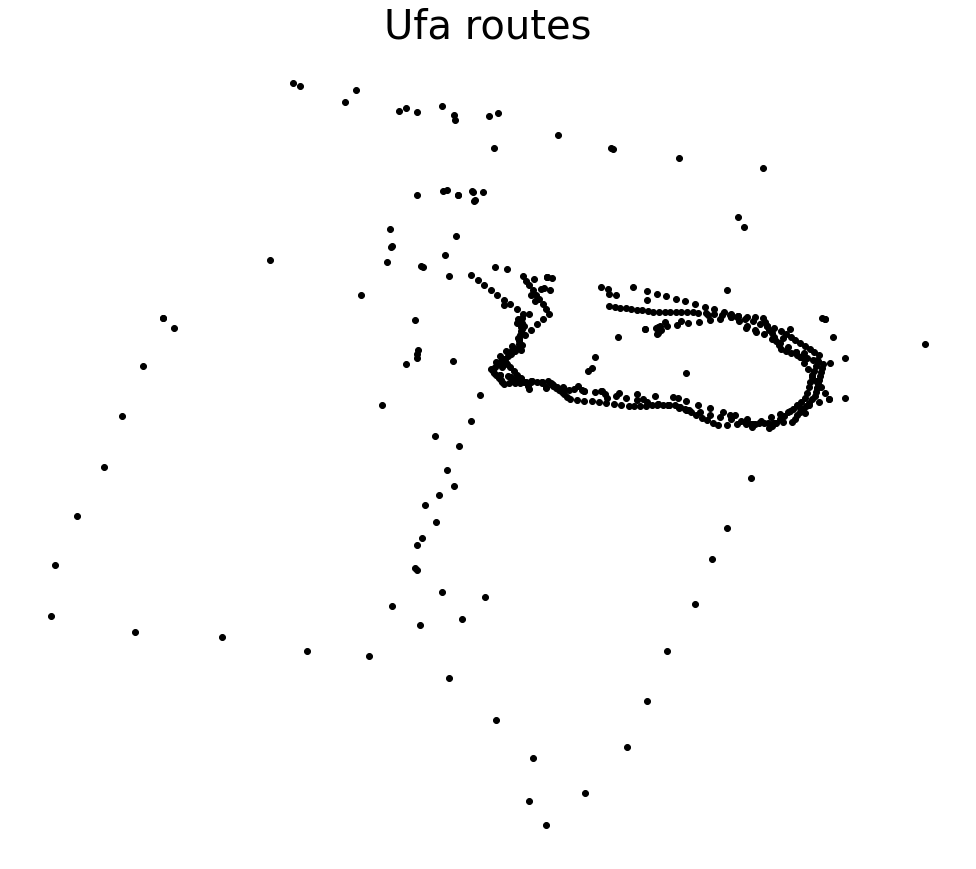

In [7]:
f, ax = plt.subplots(1, figsize=(20, 15))
ax.set_title("Ufa routes[center] bw", fontsize=40)
ax.set_axis_off()
gdf.plot(ax=ax, color='black')
plt.show()

In [8]:
# формируем массив
a=pd.Series(gdf['geometry'].apply(lambda p: p.x))
b=pd.Series(gdf['geometry'].apply(lambda p: p.y))
X=np.column_stack((a,b))

Попытка определить оптимальное кол-во кластеров, но позже в ходе эксперементов результат был точнее при большем кол-ве

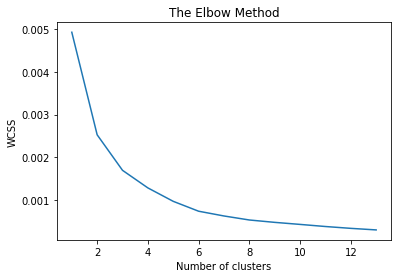

In [9]:
wcss = []
for i in range(1, 14):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 14), wcss)
plt.xlabel('Кол-во кластеров')
plt.ylabel('Сумма квадратов')
plt.show()

Создадим модель

In [10]:
kmeans = KMeans(n_clusters = n_clusters, init = 'k-means++', random_state = 5,  max_iter=400)
y_kmeans = kmeans.fit_predict(X)
k=pd.DataFrame(y_kmeans, columns=['cluster'])
gdf=gdf.join(k)

Посмотрим что получилось в цвете

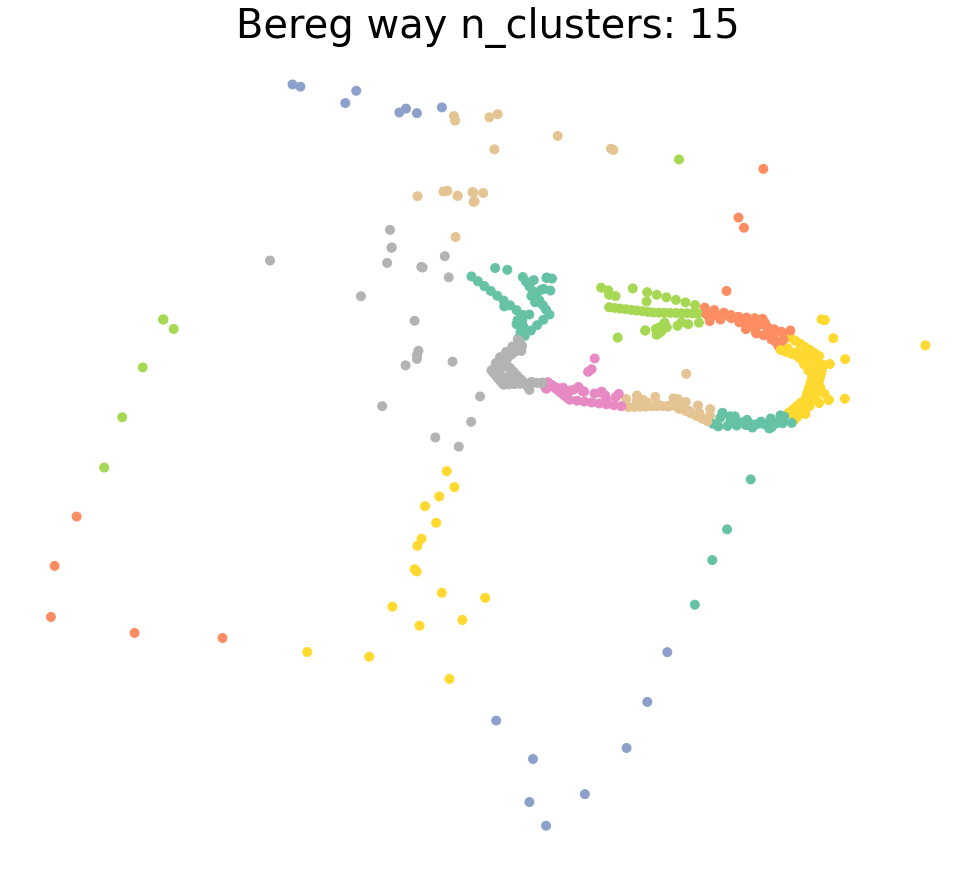

In [11]:
f, ax = plt.subplots(1, figsize=(20, 15))
ax.set_title("Ufa routes[center] color n_clusters: {}".format(n_clusters), fontsize=40)
ax.set_axis_off()
gdf.plot(column='cluster',cmap='Set2', ax=ax, markersize=80)
plt.show()

Разработка метода получения растояния в метрах между координатой и центром кластера

In [13]:
user_coord = [55.94745399, 54.72614154]
pr = kmeans.predict([user_coord])
get_claster_center = kmeans.cluster_centers_[pr[0]]
get_claster_center

user = (user_coord[1], user_coord[0]) # (lat, lon)
center_k = (get_claster_center[1], get_claster_center[0])
meters = haversine(center_k, user, Unit.METERS)
meters

56.20781858926418

In [14]:
# метод получения номера кластера
def get_cluster_number(user_coord, kmeans):
    pr = kmeans.predict([user_coord])
    return pr[0]

# потестим
get_cluster_number(user_coord, kmeans)

0

# Поиск схожих маршрутов
Тут применена лога разделение на кластеры и построение маршрута прохождения между кластерами.
Строить будем через TF-IDF, пожтому важно пропустить повтроения или застой на кластере, нужны только переходы.

In [15]:
res = []
train_for_tfidf = []
for i, row in df_sql.iterrows(): # проходим по всем маршрутам
    cls = []
    for p in row['data']['points']: # проходим по всем точкам в маршруте
        coord_u = [p['coords']['longitude'], p['coords']['latitude']]
        cl_n = get_cluster_number(coord_u, kmeans) # получаем номер кластера
        cls.append(int(cl_n))
    # сохранем только переходы
    valid_in_array = []
    start_point = cls[0]
    z = 0
    for i, cluster_number in enumerate(cls):
        if i == 0:
            valid_in_array.append(str(cluster_number))
            z += 1
            continue
        if start_point == cluster_number:
            continue
        valid_in_array.append(str(cluster_number))
        z += 1
        start_point = cluster_number
        w = "".join(valid_in_array) # кодируем маршрут в виде последовательностей
    train_for_tfidf.append(w)
    res.append([row['name'], w])
res

[['cluster1', '0136121937'],
 ['cluster2', '7391126130'],
 ['cluster3', '7391126130'],
 ['Kinbery 4 basic', '93711511'],
 ['Kinbery 4 rare', '9311511'],
 ['Kinbery 1 basic', '761301411'],
 ['Kinbery 1 rare', '7601411'],
 ['Kinbery 2 basic', '111407'],
 ['Kinbery 2 rare', '1107'],
 ['Kinbery 3 basic', '81413079'],
 ['Kinbery 3 rare', '814079'],
 ['Kinbery 5 basic', '01361937'],
 ['Kinbery 5 rare', '0136121937'],
 ['snap test 1', '71214101314136'],
 ['snap test 2', '73911261310'],
 ['snap test 3', '1028'],
 ['optimized', '39112613039113']]

#TF-IDF
Cоздаем векторное пространство, на всех данных, что у нас есть.

In [16]:
tfidfvectorizer = TfidfVectorizer(analyzer='char')
tfidf_wm = tfidfvectorizer.fit(train_for_tfidf)

# Проверка
Поиск схожего маршрута. Превращем текущий маршрут в векторное пространство, далее через косинусное подобие изем близкие вектора

In [19]:
search2 = "7391126130"
dst_euclidean = []
for r in res:
    s1 = tfidf_wm.transform([r[1]]).todense() # получаем вектор маршрута
    s2 = tfidf_wm.transform([search2]).todense() # получаем искомого маршрута
    dst = cosine_similarity(np.asarray(s1), np.asarray(s2)) # Косинусное сходство
    dst_euclidean.append({"name":r[0], "dst":dst[0][0], "route_code": r[1]})

newlist = sorted(dst_euclidean, key=lambda d: d['dst'], reverse=True) 
pd.DataFrame(newlist)

,name,dst,route_code
0,cluster1,1.000000,0136121937
1,cluster2,1.000000,7391126130
2,cluster3,1.000000,7391126130
3,Kinbery 5 rare,1.000000,0136121937
4,snap test 2,0.990019,73911261310
5,optimized,0.944954,39112613039113
6,Kinbery 5 basic,0.926548,01361937
7,snap test 1,0.795615,71214101314136
8,Kinbery 1 basic,0.781879,761301411
9,Kinbery 4 basic,0.692135,93711511
